In [4]:
import json
import math
from functools import partial
from pathlib import Path
from configparser import ConfigParser

import umap
import hdbscan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.graph_objs import Scatter, Layout, Heatmap
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import chart_studio
import chart_studio.plotly as py

from src.aggregator import *

pd.set_option('display.max_colwidth', -1)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_20372\3496233029.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Configure chart studio for interactive chart hosting

In [30]:
#create your account in https://chart-studio.plotly.com/
#add credentials to 'conf/plotly.ini'
conf=ConfigParser()
conf.read('conf/plotly.ini')
username=conf['plotly']['username']
api_key=conf['plotly']['apikey']
chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

## Data

In [5]:
df=pd.read_csv('data/interim/stenos_cleaned_topics.csv')
df.shape

(209949, 22)

In [6]:
#normalize factions
df['fation']=df.fation.replace({'Fraktsiooni mittekuuluvad saadikud': 'Fraktsioonidesse mittekuulunud Riigikogu liikmed',
                               'Fraktsiooni mittekuuluvad Riigikogu liikmed':'Fraktsioonidesse mittekuulunud Riigikogu liikmed'})

In [7]:
df_topic_clusters=pd.read_excel('data/interim/riigikogu_topics_clusters.xlsx')
df_topic_clusters['topic_words3']=df_topic_clusters.words.apply(lambda x: ' '.join(x.split()[:3]))
df_topic_clusters.shape

(1152, 9)

## Colors for plotting

In [8]:
colors=json.loads(Path('utils/colors.json').read_text())
colors=list(colors.keys())[10:]

## Add topics to original data

In [9]:
df=pd.merge(df, df_topic_clusters[['topic_cluster_id','topic_id', 'x_rand', 'y_rand']], 
            left_on='topic_id', right_on='topic_id', how='left')
df.shape

(209949, 25)

## Cluster which are noninformative

In [10]:
clusters_noninform=pd.read_csv('data/interim/noninform_clusters.csv')['0'].tolist()
topics_noninform=pd.read_csv('data/interim/noninform_topics.csv')['0'].tolist()

## Find speakers similarity

In [11]:
df_inform=df[(~df.topic_cluster.isin(clusters_noninform))&(~df.topic_id.isin(topics_noninform))]
speaker_counts=df_inform.speaker.value_counts()
speaker_counts.shape

(695,)

<AxesSubplot:>

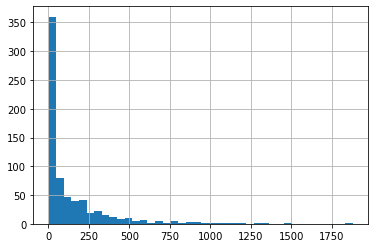

In [12]:
speaker_counts.hist(bins=40)

## Keep speakers who have a bit more data (segments) to compare

In [13]:
#keep speakers who have enough data to compare
MIN_N_SEGMENTS=100
speakers_filtered=speaker_counts[speaker_counts>MIN_N_SEGMENTS]
df_speakers_filt=df_inform[df_inform.speaker.isin(list(speakers_filtered.index))]
df_speakers_filt.shape, df_speakers_filt.speaker.nunique()

((86318, 25), 249)

In [14]:
df_speaker_topics=get_group_topics_prop(df_speakers_filt, 'speaker', 
                                        n_topics_per_group=df_speakers_filt.speaker.nunique())
df_speaker_topic_vecs=create_group_vecs(df_speaker_topics, group_col='speaker', fillna=0)

In [15]:
df_speaker_topics.shape, df_speaker_topic_vecs.shape

((23202, 4), (256, 249))

## Cluster speakers based on topics

In [16]:
reducer = umap.UMAP(random_state=42,n_components=4, metric='cosine')
embedding=reducer.fit_transform(df_speaker_topic_vecs.T)

In [17]:
#create 2d for visualization
reducer_2d = umap.UMAP(random_state=42,n_components=2, metric='cosine')
embedding_2d=reducer_2d.fit_transform(df_speaker_topic_vecs.T)

In [18]:
df_speaker_embedding=pd.DataFrame(embedding_2d)

In [20]:
#cluster data
clusterer = hdbscan.HDBSCAN()
clusterer.fit(pd.DataFrame(embedding))

HDBSCAN()

In [21]:
df_speaker_embedding['speaker']=df_speaker_topic_vecs.T.index
df_speaker_embedding['label']=clusterer.labels_
df_speaker_embedding['label_color']=df_speaker_embedding.label.apply(lambda x: colors[x])
df_speaker_embedding.shape

(249, 5)

In [22]:
#number of clusters
df_speaker_embedding.label.nunique()

14

In [23]:
df_speaker_embedding

,0,1,speaker,label,label_color
0,13.693436,13.246423,Aadu Must,3,darkorange
1,14.542329,8.931796,Ain Lutsepp,1,darkmagenta
2,9.892005,12.805812,Aivar Kokk,11,darkviolet
3,14.732650,9.038327,Aivar Riisalu,1,darkmagenta
4,9.405340,11.996966,Aivar Sõerd,11,darkviolet
...,...,...,...,...,...
244,15.270149,11.253157,Välisminister Urmas Reinsalu,2,darkolivegreen
245,12.953678,12.957911,Yana Toom,3,darkorange
246,13.290545,14.143823,Yoko Alender,3,darkorange
247,11.777964,10.203660,Õiguskantsler Indrek Teder,8,darkslateblue


In [24]:
df_speaker_embedding.label.value_counts()

-1     52
 3     31
 5     30
 11    23
 4     22
 9     16
 1     13
 2     11
 0     10
 12    10
 10    9 
 7     8 
 8     7 
 6     7 
Name: label, dtype: int64

## Review speaker clusters

In [26]:
df_speaker_embedding[df_speaker_embedding.label==0]

,0,1,speaker,label,label_color
18,11.775587,6.457350,Aseesimees Enn Eesmaa,0,darkkhaki
19,11.455017,6.646468,Aseesimees Hanno Pevkur,0,darkkhaki
20,11.677352,6.518062,Aseesimees Helir-Valdor Seeder,0,darkkhaki
21,11.643548,6.510684,Aseesimees Jüri Ratas,0,darkkhaki
22,11.611263,6.583851,Aseesimees Laine Randjärv,0,darkkhaki
23,11.398531,6.741222,Aseesimees Martin Helme,0,darkkhaki
35,11.622769,6.519792,Esimees Eiki Nestor,0,darkkhaki
36,11.478252,6.629584,Esimees Ene Ergma,0,darkkhaki
37,11.521387,6.551674,Esimees Henn Põlluaas,0,darkkhaki
38,11.534305,6.523025,Esimees Jüri Ratas,0,darkkhaki


In [27]:
#Kaja Kallas
df_speaker_embedding[df_speaker_embedding.speaker.str.contains('Kaja Kallas')]

,0,1,speaker,label,label_color
91,13.109004,11.636521,Kaja Kallas,5,darkred
166,12.423191,11.563149,Peaminister Kaja Kallas,5,darkred


In [28]:
#Jüri Ratas
df_speaker_embedding[df_speaker_embedding.speaker.str.contains('Jüri Ratas')]

,0,1,speaker,label,label_color
21,11.643548,6.510684,Aseesimees Jüri Ratas,0,darkkhaki
38,11.534305,6.523025,Esimees Jüri Ratas,0,darkkhaki
165,12.380655,11.819221,Peaminister Jüri Ratas,5,darkred


## Make plotliy scatter plot

In [31]:
# Create a trace containing the scatter plot
scatter = go.Scatter(x = df_speaker_embedding[0], y = df_speaker_embedding[1], mode = 'markers', \
                   marker= dict(size= 18, color = df_speaker_embedding['label_color'],\
                   line = dict(width = 2, color = 'rgb(0, 0, 0)')),
                   text = df_speaker_embedding['speaker']+' cluster id: '+df_speaker_embedding['label'].astype(str))

# Collect the trace(s) into the data to be plotted.
data = [scatter]

# Edit the layout
layout = dict(title = 'Speaker topic embeddings',
              xaxis = dict(title = 'x'),
              yaxis = dict(title = 'y'),
              hovermode = 'closest',
              )

# Define the figure
fig = dict(data=data, layout=layout)

# Save figure and layout into html file
plot_url = plotly.offline.plot(fig, filename='visualisations/scatter_speaker_topic_embeddings.html')
py.plot(fig, filename='scatter_speaker_topic_embeddings', auto_open = True)

'https://plotly.com/~risto.hinno/332/'